# PoseNet Tests

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML

import torch
from torch.autograd import Variable
from datasets.apolloscape import Apolloscape
from utils.common import draw_poses
from utils.common import draw_record
import numpy as np
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
import os
import time

from torchviz import make_dot

%matplotlib inline
plt.ion()


# Load Dataset

In [2]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])

# record_name = "Record029"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform, record=record_name)

# record_name = "Record018" # Record018 - example with a turn
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg", transform=transform, record=record_name)

record_name = "Record008"
apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=record_name, normalize_poses=True,
                             pose_format='quat')

print(apollo_dataset)

dataloader = DataLoader(apollo_dataset, batch_size=8) # batch_size = 75


Poses Normalized!
Dataset: Apolloscape
    Road: zpark-sample
    Record: Record008
    Length: 122 of 1499
    Normalize Poses: True
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



In [3]:
# Show images
def imshow(img, title=None):
    img = img.numpy().transpose([1, 2, 0])
    fig = plt.figure(figsize=(18, 18))
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.pause(0.001)

len(batch) = 2
len(batch[0]) = 2
len(batch[0][0]) = 8
batch_poses[0] =  tensor([-0.6945, -1.3569, -0.4478,  0.6075, -0.7607, -0.2002,  0.1106])
unnormalized pose =  [ 3.64254999e+02 -2.59376300e+03  4.00460000e+01  6.07490599e-01
 -7.60674477e-01 -2.00217381e-01  1.10645652e-01]


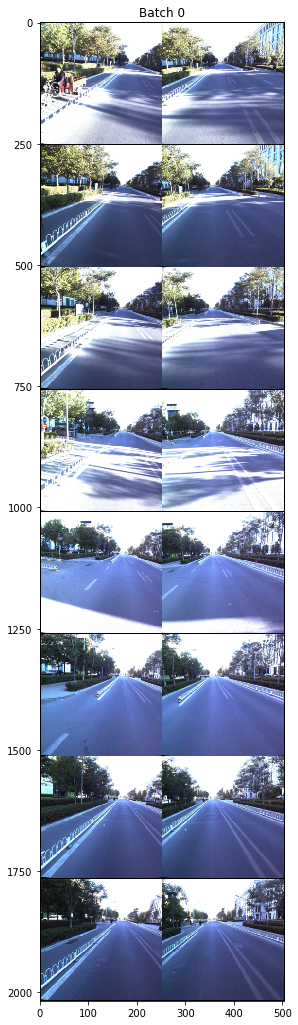

In [4]:
def collate_batch_images(batch_samples):
    just_images = [torch.cat(x, dim=2) for x in zip(*batch_samples[0])]
    return just_images


dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)

print('len(batch) = {}'.format(len(batch)))
print('len(batch[0]) = {}'.format(len(batch[0])))
print('len(batch[0][0]) = {}'.format(len(batch[0][0])))

print('batch_poses[0] = ', batch[1][0][0])
pose = batch[1][0][0]
npose = np.zeros(7)
npose[:3] = pose.numpy()[:3] * apollo_dataset.poses_std[:3] + apollo_dataset.poses_mean[:3]
npose[3:] = pose.numpy()[3:]
pose = npose
print('unnormalized pose = ', pose)

images_col = collate_batch_images(batch)

img_out = vutils.make_grid(images_col, nrow=1)
imshow(img_out, title="Batch 0")

In [6]:
class PoseNet(torch.nn.Module):
    
    def __init__(self, feature_extractor, num_features=128):
        super(PoseNet, self).__init__()
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)
        
        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def forward(self, x):
        # x is batch_images [2 x batch_size]
        
#         x = self.feature_extractor(x[0])

#         for xi in x:
#             print('type xi = {}'.format(type(xi)))
        
        x_features = [self.feature_extractor(xi) for xi in x]
        x_translations = [self.fc_xyz(xi) for xi in x_features]
        x_rotations = [self.fc_quat(xi) for xi in x_features]
        
        x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]
        
        return x_poses


# Create model
feature_extractor = models.resnet18(pretrained=True)
model = PoseNet(feature_extractor)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

# feature_extractor = torch.nn.Sequential()
# feature_extractor.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4,
#                     stride=2, padding=1, bias=True))
# feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))
# feature_extractor.add_module('relu1', torch.nn.LeakyReLU(0.2, inplace=False))

# print(model)


In [7]:
# test_imgs1 = torch.rand(10, 3, 250, 250)
# test_imgs2 = torch.rand(10, 3, 250, 250)
batch_images = [torch.rand(10, 3, 250, 250) for _ in range(2)]
batch_poses = [torch.rand(10, 7) for _ in range(2)]

# for idx, m in enumerate(feature_extractor.modules()):
#     print("{} -> {}".format(idx, m))
# print('out.len = {}'.format(len(out)))
# print('out[0].len = {}'.format(len(out[0])))
# batch_poses



def get_loss(pred, target):
    loss_fn = torch.nn.L1Loss()
    # Translation + Rotation loss
    loss = loss_fn(pred[0], target[0])
    loss += loss_fn(pred[1], target[1])
    return loss


out = model(batch_images)
print('out = {}'.format(out))

loss = get_loss(out, batch_poses)
print('loss = {}'.format(loss))

optimizer.zero_grad()
loss.backward()
optimizer.step()


# batch_poses[0][:, :3, 3].size()




out = [tensor([[-0.6629,  0.0918,  0.1848,  0.0859, -0.0541, -0.1699, -0.4009],
        [-0.8311, -0.1434,  0.1365,  0.3141, -0.1720,  0.3403, -0.3988],
        [-0.8648, -0.1839,  0.3740,  0.1142, -0.1931,  0.2219, -0.3641],
        [-0.5133,  0.2756,  0.0583,  0.0344,  0.0729,  0.0314, -0.5004],
        [-0.5006,  0.0120,  0.3111,  0.2324, -0.1646,  0.3911, -0.3748],
        [-0.6618,  0.0080,  0.1443,  0.1843,  0.0099,  0.3719, -0.3584],
        [-0.6633,  0.0566,  0.1409,  0.1929, -0.0338,  0.0559, -0.6823],
        [-0.4100,  0.4986,  0.0132,  0.0809, -0.0423, -0.0565, -0.5482],
        [-0.5741, -0.1145,  0.0883,  0.1907,  0.0022,  0.0087, -0.4085],
        [-0.7597,  0.0910,  0.2700, -0.0104, -0.0746,  0.3260, -0.3078]]), tensor([[-0.5772, -0.1462, -0.0739, -0.0608, -0.1085,  0.1921, -0.2893],
        [-0.2257,  0.1107,  0.2242,  0.0511, -0.1713,  0.2104, -0.3415],
        [-0.6858,  0.2386,  0.2799, -0.0287,  0.0005,  0.3645, -0.7212],
        [-0.8371,  0.2860,  0.2374,  0.502

In [8]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cpu


In [9]:
model = PoseNet(feature_extractor)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

n_epochs = 1
for e in range(n_epochs):
    for idx, (batch_images, batch_poses) in enumerate(dataloader):
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        out = model(batch_images)
        loss = get_loss(out, batch_poses)
        print('Epoch: {}, Batch: {} of {}, Loss: {}'.format(e, idx * dataloader.batch_size, len(apollo_dataset), loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx >= 1:
            break


Epoch: 0, Batch: 0 of 122, Loss: 1.5616700649261475
Epoch: 0, Batch: 8 of 122, Loss: 1.6862787008285522


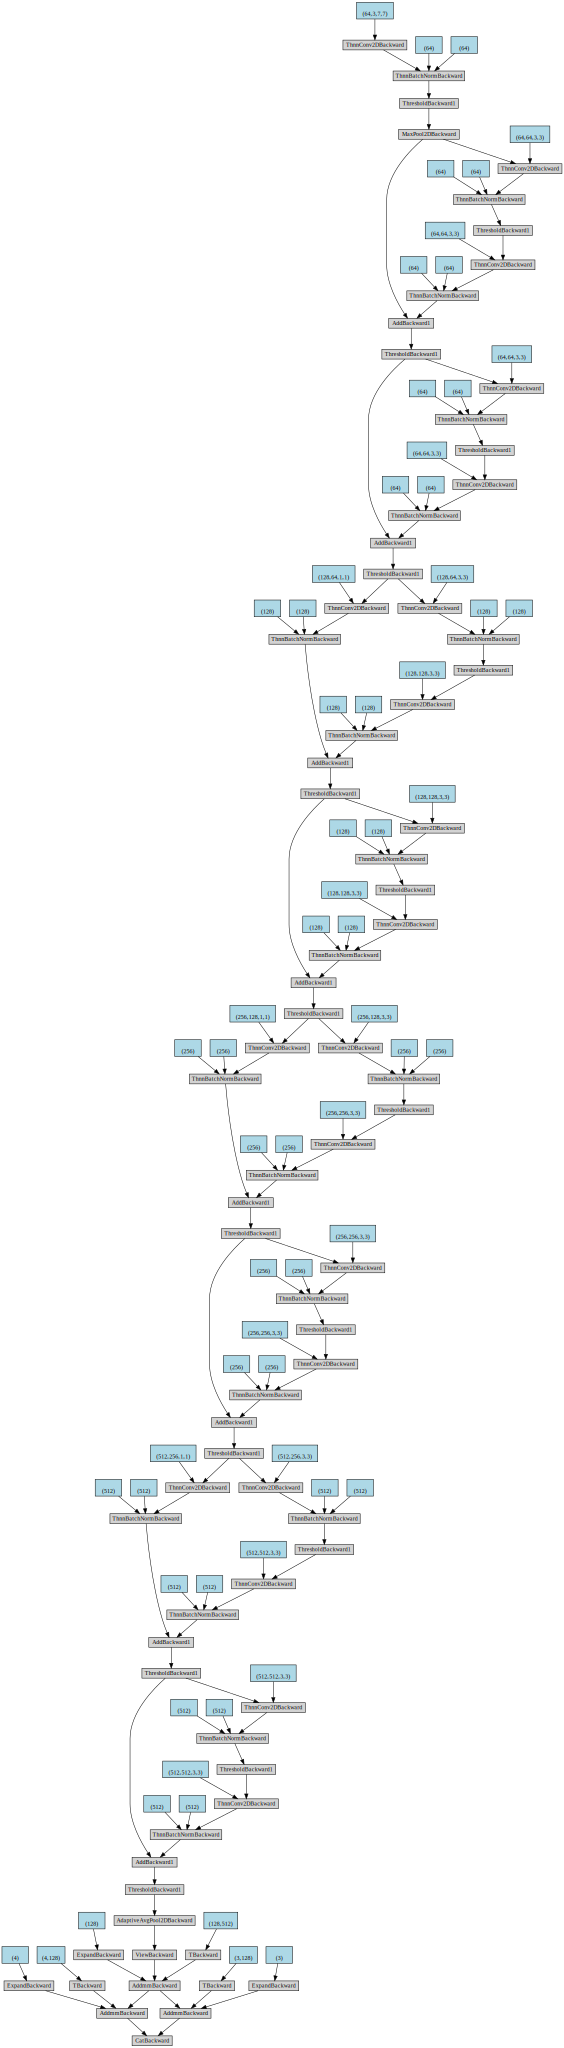

In [10]:
# for p in feature_extractor.parameters():
#     print(p.size())

# Test function for visiting backward graph
visited = set()
def visit_all(var, indent=''):
    if hasattr(var, 'data'):
        print("{}Data: {}".format(indent, var.data.size()))
    if hasattr(var, 'grad'):
        print("{}Grad Data: {}".format(indent, var.grad))
    if torch.is_tensor(var):
        print("{}Tensor {}".format(indent, var.size()))
    else:
        print("{}Type: {}".format(indent, type(var)))

    if hasattr(var, 'variable'):
        print("{}Variable: {}".format(indent, var.variable.size()))
        print("{}Data: {}".format(indent, var.variable))
        print("{}Data GRAD: {}".format(indent, var.variable.grad))
    if hasattr(var, 'saved_tensors'):
        print('{}Saved tensors: {}'.format(indent, var.saved_tensors))
    if hasattr(var, 'next_functions'):
        print('{}Next functions: {}'.format(indent, var.next_functions))
        for f in var.next_functions:
            if f[0] is not None:
                print("{}Function: {}".format(indent, f))
                visit_all(f[0], indent=indent+'  ')
    if hasattr(var, 'grad_fn'):
        print('{}Grad Fn: {}'.format(indent, var.grad_fn))
        visit_all(var.grad_fn, indent=indent+'  ')
    visited.add(var)
    
    
# visit_all(y)

# print(out.grad_fn.next_functions)

# out.__dir__()
# make_dot(out, params=dict(feature_extractor.named_parameters()))
make_dot(out[0])

a = tensor([ 0.8685])
b = tensor([ 0.3872])
c = tensor([ 0.6329])
y = tensor(1.00000e-02 *
       [-9.0358])


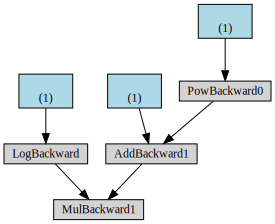

In [11]:
# Simple experiment to check backward graph state
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
c = torch.rand(1, requires_grad=True)
y = torch.log(a) * (b + torch.pow(c, 3))
print('a = {}'.format(a))
print('b = {}'.format(b))
print('c = {}'.format(c))
print('y = {}'.format(y))

# visit_all(y)
# print('--- BACKWARD ---')
# y.backward()
# visit_all(y)

make_dot(y)